<a href="https://colab.research.google.com/github/ketoin23/Multimodal-Classification-of-Social-Media-Images/blob/main/MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Dropout, LSTM
import os
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from google.colab import files
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import classification_report, hamming_loss
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.manifold import TSNE
import networkx as nx
from collections import Counter
import itertools
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, TFAutoModel

In [ ]:
!unzip '/content/drive/MyDrive/Mini/Dataset.zip'

Archive:  /content/drive/MyDrive/Mini/Dataset.zip
replace Dataset/desc.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Dataset/desc.csv        
  inflating: Dataset/Animals/1015584366.jpg  
  inflating: Dataset/Animals/1001773457.jpg  
  inflating: Dataset/Animals/1003163366.jpg  
  inflating: Dataset/Animals/1009434119.jpg  
  inflating: Dataset/Animals/1012212859.jpg  
  inflating: Dataset/Animals/101654506.jpg  
  inflating: Dataset/Animals/1019077836.jpg  
  inflating: Dataset/Animals/1019604187.jpg  
  inflating: Dataset/Animals/1020651753.jpg  
  inflating: Dataset/Animals/1022975728.jpg  
  inflating: Dataset/Animals/1024138940.jpg  
  inflating: Dataset/Animals/1026685415.jpg  
  inflating: Dataset/Kids/1015118661.jpg  
  inflating: Dataset/Kids/1000268201.jpg  
  inflating: Dataset/Kids/1002674143.jpg  
  inflating: Dataset/Kids/1006452823.jpg  
  inflating: Dataset/Kids/1007320043.jpg  
  inflating: Dataset/Kids/1010673430.jpg  
  inflating: Dataset/Kids/1012150929.

In [ ]:
df = pd.read_csv('Dataset/desc.csv')
df.index.name = 'idx'
df

,ID,path,Desc,Label
idx,,,,
0,101654506,Animals/101654506.jpg,The white and brown dog is running over the su...,Animal
1,1001773457,Animals/1001773457.jpg,A black dog and a white dog with brown spots a...,Animal
2,1003163366,Animals/1003163366.jpg,a man sleeping on a bench outside with a white...,Animal
3,1009434119,Animals/1009434119.jpg,1009434119.jpg| 0| A black and white dog is ru...,Animal
4,1012212859,Animals/1012212859.jpg,1012212859.jpg| 0| White dog with brown ears s...,Animal
...,...,...,...,...
91,1010087179,Working/1010087179.jpg,1010087179.jpg| 0| A tan man with a backwards ...,Working
92,1010087623,Working/1010087623.jpg,1010087623.jpg| 0| A caucasian man wearing a s...,Working
93,1010470346,Working/1010470346.jpg,1010470346.jpg| 0| two men in florescent vests...,Working


In [ ]:
le = LabelEncoder()
le.fit(df['Label'])
df['Label'] = le.transform(df['Label'])

#TEXT PREPROCESSING

Remove Special characters and .jpg from text

In [ ]:
pattern = r'[^a-zA-Z\s]'
df['Desc'] = df['Desc'].str.replace(pattern, '')

word_to_remove = 'jpg'
df['Desc'] = df['Desc'].str.replace(word_to_remove, '')

<ipython-input-84-3e4e15903fd8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Desc'] = df['Desc'].str.replace(pattern, '')


Lowercase

In [ ]:
df['Desc'] = df['Desc'].str.lower()

Tokenization

In [ ]:
nltk.download('punkt')
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens
df['token'] = df['Desc'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Remove Stopwords

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['token'] = df['token'].apply(lambda x: [word for word in x if not word in stop_words])
df['Desc'] = df['Desc'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    # use part-of-speech (POS) tagging to improve lemmatization accuracy
    pos_tags = nltk.pos_tag(tokens)
    # map POS tags to WordNet tags
    wn_tags = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    # lemmatize each token using its associated POS tag
    lemmas = []
    for token, pos in pos_tags:
        wn_tag = wn_tags.get(pos[0], 'n')
        lemma = lemmatizer.lemmatize(token, wn_tag)
        lemmas.append(lemma)
    return lemmas

df['token'] = df['token'].apply(lemmatize_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


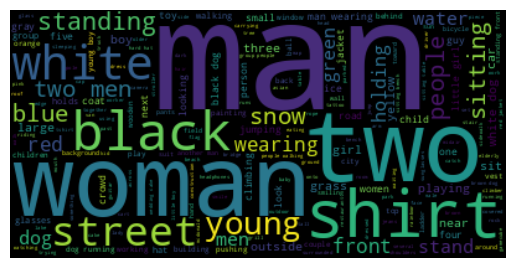

In [ ]:
wordcloud = WordCloud().generate(' '.join(df['Desc']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

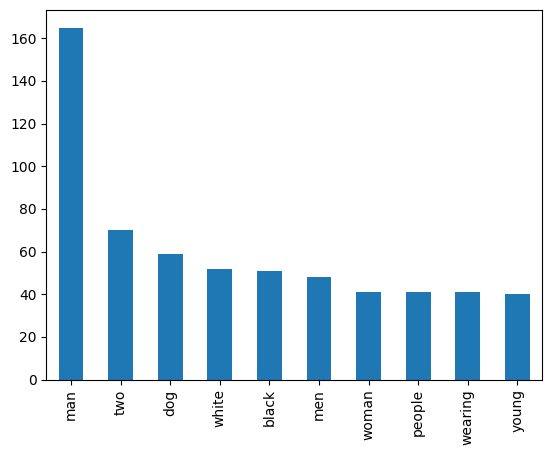

In [ ]:
word_freq = pd.Series(' '.join(df['Desc']).split()).value_counts()
word_freq[:10].plot(kind='bar')
plt.show()

BERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = TFAutoModel.from_pretrained('bert-base-uncased')
texts = df['Desc']

def generate_bert_embedding(text):
    input_ids = tf.constant(tokenizer.encode(text, add_special_tokens=True))[None, :]  # add batch dimension
    embeddings = model(input_ids)[0][:, 0, :].numpy()  # extract embeddings for [CLS] token
    return embeddings.tolist()[0]

df['bert_embedding'] = texts.apply(generate_bert_embedding)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
df.bert_embedding[0]

[-0.5935444831848145,
 0.04076292738318443,
 -0.1228356808423996,
 0.011354267597198486,
 -0.0782153382897377,
 -0.048000313341617584,
 0.47778385877609253,
 0.5830186605453491,
 -0.7533393502235413,
 -0.0979163646697998,
 -0.16592395305633545,
 -0.25357964634895325,
 -0.21673204004764557,
 0.3078596889972687,
 0.19353696703910828,
 -0.08846313506364822,
 0.026367295533418655,
 0.6506996750831604,
 0.37978172302246094,
 0.06524158269166946,
 -0.1402876377105713,
 -0.5577683448791504,
 -0.19916188716888428,
 -0.09538178145885468,
 0.12554527819156647,
 -0.18159492313861847,
 0.08073872327804565,
 0.21514227986335754,
 0.07206752896308899,
 0.16744518280029297,
 -0.10766592621803284,
 -0.04032395780086517,
 -0.08819755911827087,
 -0.1488349884748459,
 0.5069816708564758,
 -0.25069984793663025,
 0.9644205570220947,
 -0.24942824244499207,
 0.11773715168237686,
 0.2384251356124878,
 -0.049739301204681396,
 0.41829103231430054,
 0.49042606353759766,
 -0.05980989336967468,
 0.0394760593771934

In [ ]:
len(df.bert_embedding[0])

768

In [ ]:
bert_embeddings = np.array(df['bert_embedding'].tolist())
bert_embeddings.shape

(96, 768)

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, learning_rate= 0.001)
embeddings_2d = tsne.fit_transform(bert_embeddings)

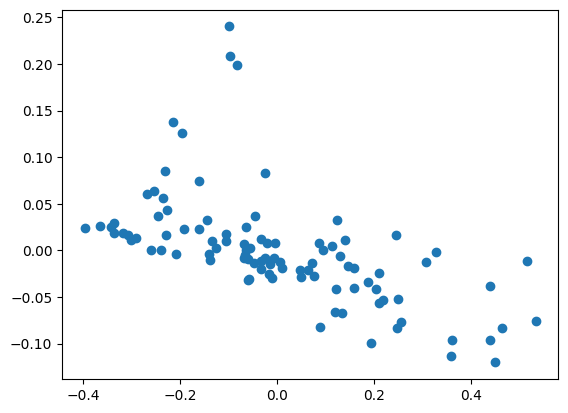

In [ ]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
embedded = tsne.fit_transform(bert_embeddings)

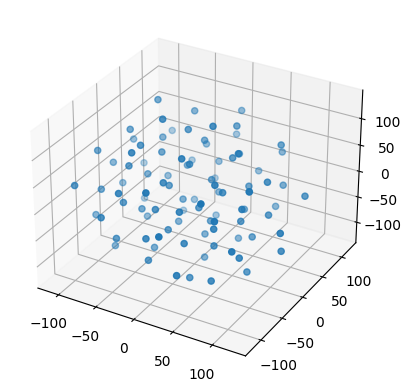

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded[:,0], embedded[:,1], embedded[:,2])
plt.show()

In [ ]:
if df.bert_embedding[21] == generate_bert_embedding(df.Desc[21]):
  print('Works')
else:
  print('Mismatch')

Works


In [ ]:
df_text = pd.DataFrame(bert_embeddings)
df_text.index.name = 'idx'
df_text = pd.concat([df_text, df['Label']], axis=1)
df_text

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,Label
idx,,,,,,,,,,,,,,,,,,,,,
0,-0.593544,0.040763,-0.122836,0.011354,-0.078215,-0.048000,0.477784,0.583019,-0.753339,-0.097916,...,-0.202820,-0.345233,0.293576,0.272779,-0.070159,-0.001641,-0.257509,0.157412,0.361761,0
1,-0.494473,0.096372,-0.274599,-0.347349,-0.307484,-0.156852,0.461654,0.252722,-0.473903,-0.455049,...,-0.026336,-0.244021,0.228893,0.213188,0.003922,-0.158955,-0.657244,0.219035,0.268692,0
2,-0.303565,-0.192125,-0.014276,-0.171649,0.328319,-0.289836,0.275179,0.457705,-0.822046,-0.236782,...,-0.194309,-0.346030,-0.153259,0.415925,0.122923,0.240783,-0.350069,0.211804,-0.119822,0
3,-0.633845,-0.327255,-0.348847,0.005620,0.556315,-0.128623,0.032728,0.773136,-0.713009,-0.091628,...,-0.511506,-0.429551,0.255409,0.537955,-0.139638,-0.244622,-0.399803,0.080234,0.137464,0
4,-0.514477,-0.158042,0.006711,-0.081906,0.029297,-0.191829,0.435017,0.477927,-0.668368,-0.248695,...,-0.363534,-0.092700,0.371533,0.581360,0.009555,-0.101222,-0.205446,-0.132332,0.206354,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.107951,0.262973,0.022788,-0.237970,-0.014990,0.205004,0.555834,0.331264,-0.832281,-0.344381,...,-0.113813,-0.153436,0.378423,0.306543,0.198286,-0.105704,-0.570781,0.151182,-0.037277,5
92,-0.139078,0.121032,-0.138894,-0.205817,0.377015,0.182716,0.397011,0.455310,-0.678668,-0.304891,...,-0.616120,-0.114415,0.281106,0.485580,0.367949,-0.058420,-0.420720,-0.080995,-0.016868,5
93,-0.030407,-0.262579,0.084559,-0.279318,0.075380,-0.461315,0.307820,0.541047,-0.767550,-0.842471,...,-0.655188,-0.204825,0.244604,0.409310,-0.036409,-0.039758,-0.766684,0.256624,-0.289485,5


In [ ]:
X = df_text.drop('Label', axis = 1)
y = df_text['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.65

#Image Processing

In [ ]:
df_temp = df.sample(frac=1).reset_index(drop=True)

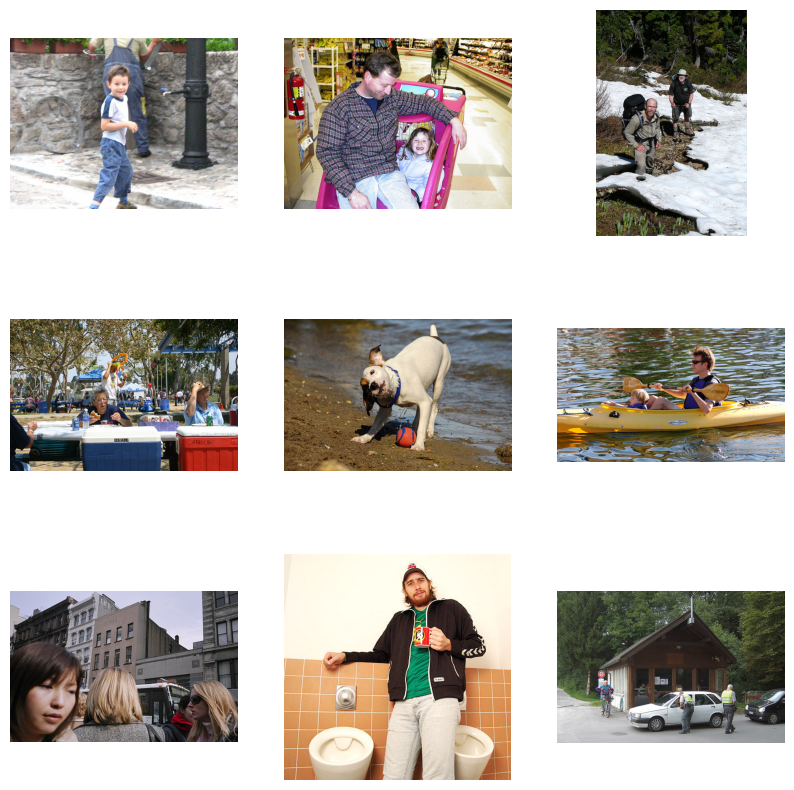

In [ ]:
folder = 'Dataset'
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, row in df_temp.head(9).iterrows():
    image_path = os.path.join(folder, row['path'])
    image = mpimg.imread(image_path)
    axs[i//3, i%3].imshow(image)
    axs[i//3, i%3].axis('off')

plt.show()

In [ ]:
folder = 'Dataset'
target_size = (250,250)
image_list = []
def preprocess_image(image_path, target_size):
    image_path = os.path.join(folder, image_path)
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

In [ ]:
images = []

for image_path in df['path']:
    image = preprocess_image(image_path, target_size)
    images.append(image)
images = np.concatenate(images, axis=0)

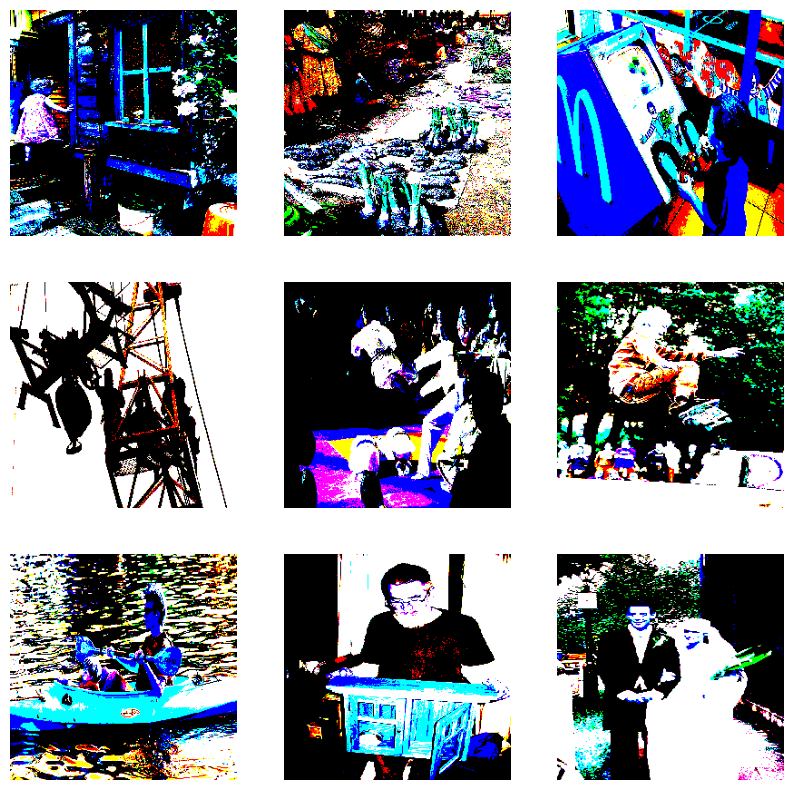

In [ ]:
temp_images = images
temp_images = np.array(temp_images)
temp_images = np.random.permutation(temp_images)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
  axs[i//3, i%3].imshow(temp_images[i])
  axs[i//3, i%3].axis('off')

In [ ]:
len(images)

96

In [ ]:
images[0].shape

(250, 250, 3)

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
# model = tf.keras.models.Sequential([
#     vgg,
#     tf.keras.layers.GlobalAveragePooling2D()
# ])
def get_embeddings(images):
  embeddings = vgg.predict(images)
  embeddings = embeddings.reshape(embeddings.shape[0], -1)
  return embeddings

vgg_embeddings = get_embeddings(images)

3/3 [==============================] - 77s 25s/step


In [ ]:
vgg_embeddings[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
vgg_embeddings[0].shape

(25088,)

In [ ]:
vgg_embeddings.shape

(96, 25088)

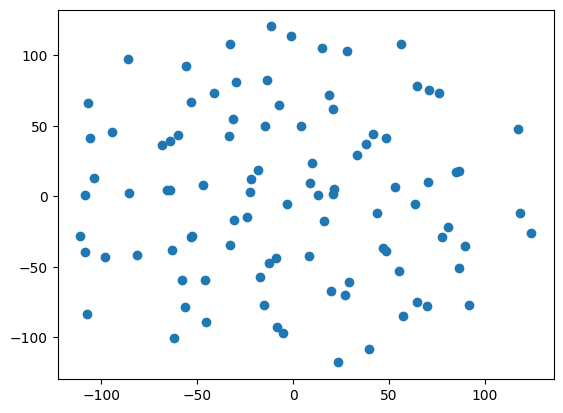

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, learning_rate= 0.001)
embeddings_2d = tsne.fit_transform(vgg_embeddings)

plt.scatter(embedded[:,0], embedded[:,1])
plt.show()

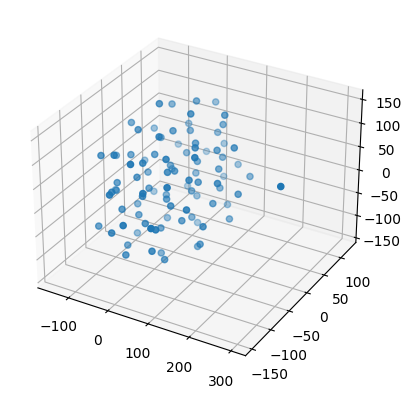

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
embedded = tsne.fit_transform(vgg_embeddings)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded[:,0], embedded[:,1], embedded[:,2])
plt.show()

In [ ]:
df_image = pd.DataFrame(vgg_embeddings)
df_image.index.name = 'idx'
df_image = pd.concat([df_image, df['Label']], axis=1)
df_image

,0,1,2,3,4,5,6,7,8,9,...,25079,25080,25081,25082,25083,25084,25085,25086,25087,Label
idx,,,,,,,,,,,,,,,,,,,,,
0,0.00000,0.0,0.000000,0.000000,2.043249,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0
1,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,33.313194,0.0,0.0,0.0,0.000000,0.0,0.000000,0
2,0.00000,0.0,0.000000,0.300089,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0
3,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0
4,0.00000,0.0,0.000000,35.365990,4.798837,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4.76207,0.0,0.000000,0.000000,15.304661,0.0,0.0,10.037679,0.0,0.0,...,51.518723,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,14.808141,5
92,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,12.282824,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,5
93,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,5


In [ ]:
X = df_image.drop('Label', axis = 1)
y = df_image['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.45

#Multimodal Classification Methods


##Early Fusion (Concatenation)

In [ ]:
concatenated_array = np.concatenate([vgg_embeddings, bert_embeddings], axis=1)
concatenated_array.shape

(96, 25856)

In [ ]:
vgg_embeddings.shape

(96, 25088)

In [ ]:
bert_embeddings.shape

(96, 768)

In [ ]:
df_multi = pd.DataFrame(concatenated_array)
df_multi.index.name = 'idx'

df_multi.columns = df_multi.columns.astype(str)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_multi)
df_multi = pd.DataFrame(normalized_data, columns=df_multi.columns)

df_multi = pd.concat([df_multi, df['Label']], axis=1)
df_multi

,0,1,2,3,4,5,6,7,8,9,...,25847,25848,25849,25850,25851,25852,25853,25854,25855,Label
0,0.000000,0.0,0.0,0.000000,0.028563,0.0,0.0,0.000000,0.0,0.0,...,0.822385,0.274405,0.568702,0.341136,0.285970,0.472220,0.631099,0.522943,0.701798,0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,1.000000,0.385748,0.495622,0.269098,0.350049,0.269387,0.135645,0.601976,0.624837,0
2,0.000000,0.0,0.0,0.008485,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.830951,0.273528,0.063860,0.514183,0.452983,0.784791,0.516374,0.592702,0.303568,0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.511721,0.181647,0.525581,0.661702,0.225872,0.158931,0.454732,0.423961,0.516323,0
4,0.000000,0.0,0.0,1.000000,0.067084,0.0,0.0,0.000000,0.0,0.0,...,0.660641,0.552217,0.656779,0.714174,0.354921,0.343825,0.695628,0.151342,0.573290,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.155869,0.0,0.0,0.000000,0.213946,0.0,0.0,0.107919,0.0,0.0,...,0.911962,0.485402,0.664563,0.381953,0.518170,0.338046,0.242813,0.514953,0.371827,5
92,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.132057,0.0,0.0,...,0.406437,0.528328,0.554614,0.598387,0.664925,0.399013,0.428806,0.217181,0.388703,5
93,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.367119,0.428868,0.513372,0.506186,0.315164,0.423073,0.000000,0.650184,0.163271,5
94,0.000000,0.0,0.0,0.000000,0.241989,0.0,0.0,0.000000,0.0,0.0,...,0.453432,0.568908,0.291487,0.763307,0.483223,0.657723,0.457113,0.223815,0.292920,5


In [ ]:
df_multi['Label'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
df_multi2 = pd.DataFrame(concatenated_array)
df_multi2.index.name = 'idx'
df_multi2 = pd.concat([df_multi2, df['Label']], axis=1)
df_multi2.columns = df_multi2.columns.astype(str)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_multi2)
df_multi2 = pd.DataFrame(normalized_data, columns=df_multi2.columns)

In [ ]:
df_multi = df_multi.sample(frac = 1)

In [ ]:
X = df_multi.drop('Label', axis = 1)
y = df_multi['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X2 = df_multi2.drop('Label', axis = 1)
y2 = df_multi2['Label']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=1)

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.4

In [ ]:
num_classes = len(df_multi['Label'].unique())
model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(concatenated_array.shape[1],)))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model2 = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(concatenated_array.shape[1],)))
# model.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
y = to_categorical(y, num_classes = 6)

y_train2 = to_categorical(y_train2, num_classes=6)
y_test2 = to_categorical(y_test2, num_classes=6)
y2 = to_categorical(y, num_classes = 6)

In [ ]:
%%capture
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [ ]:
model2.fit(X_train2, y_train2, epochs=3, validation_data=(X_test2, y_test2))

Epoch 1/3
1/3 [=========>....................] - ETA: 0s - loss: 1.7162 - accuracy: 0.2500

3/3 [==============================] - 1s 113ms/step - loss: 1.2077 - accuracy: 0.5789 - val_loss: 0.7732 - val_accuracy: 0.8000
Epoch 2/3
3/3 [==============================] - 0s 31ms/step - loss: 0.3158 - accuracy: 0.8289 - val_loss: 0.6724 - val_accuracy: 0.8000
Epoch 3/3
3/3 [==============================] - 0s 29ms/step - loss: 0.0850 - accuracy: 1.0000 - val_loss: 0.5971 - val_accuracy: 0.8000


In [ ]:
y_test[0]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
y_pred = model.predict(X)

3/3 [==============================] - 0s 8ms/step


In [ ]:
pred = np.zeros_like(y_pred)
pred[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1

In [ ]:
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y, axis = 1)

In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.53      0.70        15
           2       0.84      0.80      0.82        20
           3       0.78      0.88      0.82        16
           4       0.93      0.93      0.93        15
           5       0.77      0.94      0.85        18

    accuracy                           0.84        96
   macro avg       0.86      0.85      0.84        96
weighted avg       0.86      0.84      0.84        96



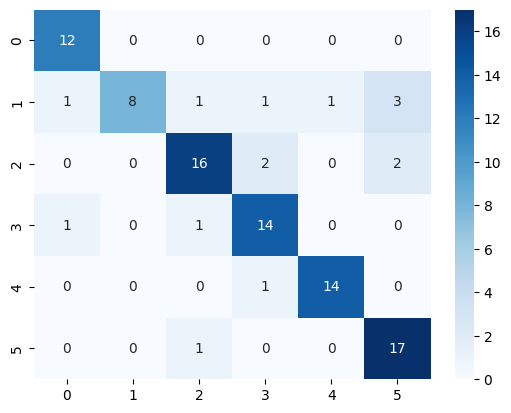

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

##Fusion using MLP

In [ ]:
labels = to_categorical(df['Label'], num_classes = 6)

In [ ]:
# scaler2 = MinMaxScaler()
# bert_embeddings = scaler2.fit_transform(bert_embeddings)
# scaler3 = MinMaxScaler()
# vgg_embeddings = scaler3.fit_transform(vgg_embeddings)

In [ ]:
shuffled_indices = np.random.permutation(len(bert_embeddings))
bert_embeddings = bert_embeddings[shuffled_indices]
vgg_embeddings = vgg_embeddings[shuffled_indices]
labels = labels[shuffled_indices]

In [ ]:
text_input = Input(shape=(768,), name='text_input')
image_input = Input(shape=(25088,), name='image_input')

text_mlp = Dense(64, activation='relu')(text_input)
image_mlp = Dense(64, activation='relu')(image_input)

fusion = Concatenate()([text_mlp, image_mlp])

output = Dense(num_classes, activation='softmax')(fusion)

model2 = Model(inputs=[text_input, image_input], outputs=output)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit({'text_input': bert_embeddings, 'image_input': vgg_embeddings}, labels, epochs=3, validation_split=0.2)

Epoch 1/3
1/3 [=========>....................] - ETA: 1s - loss: 12.4880 - accuracy: 0.2500

3/3 [==============================] - 1s 125ms/step - loss: 13.5213 - accuracy: 0.2632 - val_loss: 20.3503 - val_accuracy: 0.3500
Epoch 2/3
3/3 [==============================] - 0s 36ms/step - loss: 4.9440 - accuracy: 0.8026 - val_loss: 14.7363 - val_accuracy: 0.2500
Epoch 3/3
3/3 [==============================] - 0s 36ms/step - loss: 0.2393 - accuracy: 0.9474 - val_loss: 12.2836 - val_accuracy: 0.3500
